In [1]:
# import all modules
import shutil
import glob
import csv
import ast
import os
import re

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem

from mendeleev import element

from rdkit import Chem
import seaborn as sns
import pandas as pd
import numpy as np

from astroquery.linelists.cdms import CDMS
from astroquery.jplspec import JPLSpec
import astropy.units as u
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [3]:
## CDMS ##
# phosphine, methanol, formic acid, not used: cyclopropene,'040506 c-C3H4'
CDMS_molecule_list = ['034501 PH3','032504 CH3OH','046506 t-HCOOH']

## JPL ##
# acetonitrile, acetaldehyde, methylformate
JPL_molecule_list = ['41001 CH3CN','44003 CH3CHO','60003 CH3OCHO']

molecule_names_list = [r'Phosphine - PH$_3$', r'Methanol - CH$_3$OH', 
                       r'Formic Acid - HCOOH', r'Acetonitrile - CH$_3$CN',
                       r'Acetaldehyde - CH$_3$CHO', r'Methylformate - CH$_3$OCHO']

all_list = [('034501 PH3',r'Phosphine - PH$_3$','CDMS',0,0,'P'),('032504 CH3OH',r'Methanol - CH$_3$OH','CDMS',0,1,'OC'),
           ('046506 t-HCOOH',r'Formic Acid - HCOOH','CDMS',1,0,'O=CO'),('41001 CH3CN',r'Acetonitrile - CH$_3$CN','JPL',1,1,'N#CC'),
           ('44003 CH3CHO',r'Acetaldehyde - CH$_3$CHO','JPL',2,0,'O=CC'),('60003 CH3OCHO',r'Methylformate - CH$_3$OCHO','JPL',2,1,'O=COC')]

In [4]:
data_ground = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/B971_def2TZVPD_DataFile1_GroundState.csv')
data_all = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/B971_def2TZVPD_DataFile1.csv')
data = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/6_Atoms/biosig_CHNOPS.csv')
data_ground[data_ground['Formula']=='CH4O']

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Formula,SMILES,# Atoms,Conf#,Rotamer Degeneracy,Relative Energy [kJ/mol],BW Percent at 10 K,...,mu_b [D],mu_c [D],mu_tot [D],mu_amu_bmu_c,A [cm-1],B [cm-1],C [cm-1],Flag1,Flag2,Flag3
44,46,46,46,CH4O,OC,6,CONF1,3,0.0,100.0,...,-1.393634,-0.000534,1.632406,0.000633,4.270612,0.826271,0.797623,Conformer Retained,Present,Complete


In [172]:
data[data['IUPAC_chemname']=='methyl formate']

,Unnamed: 0,Formula,Formula_ID,Tot_atoms,Tot_nH_atoms,Tot_H_atoms,SMILES,Dataset_no,Molecular_weight,IUPAC_chemname,...,EPISUITE,InChI_Code,InChI_Key,Boiling_Point,BP_basis,EPIsuite_output,MP,Basis,Life,CHNOPS
175,175,C2H4O2,C2H4O2_4,8,4,4,O=COC,213,60.052,methyl formate,...,O=COC,"InChI=1S/C2H4O2/c1-4-2-3/h2H,1H3",InChIKey=TZIHFWKZFHZASV-UHFFFAOYSA-N,31.41378472,Ex,28.88(BP est) -99.48(MP est) 31.70(...,-99,Expt,Y,Y


# Functions

In [33]:
def have_hyperfine(file):
    with open(file, 'r') as inp:
        for line in inp:
            line = line.strip()
            if line.startswith('Atoms with significant hyperfine tensors:'):
                if len(line.split()) == 5:
                    hyperfine = 'No'
                elif len(line.split()) > 5:
                    hyperfine = 'Yes'
    return hyperfine
    

In [26]:
def grab_constant(inp,quartic_constants):
    rot_info = next(inp).split()
    quartic_constants.append(float(rot_info[3])/29979.2458)
    return

def get_quartic_rotational_constants(file): 
    quartic_constants = []
    with open(file, 'r') as inp:
        for line in inp:
            line = line.strip()
            if line.startswith('(Asymmetrically reduced)          (Symmetrically reduced)'):
                for n in range(0,5,1):
                    grab_constant(inp,quartic_constants)
    return quartic_constants

In [27]:
## get lines from CDMS ## 
def CDMS_get_frequencues_intensities(molecule):
    ''' Grabs frequency and intensity data from CDMS for a molecule.
    
    Parameters 
    ----------
    molecule: string
              CDMS code for molecule, as given in https://cdms.astro.uni-koeln.de/cgi-bin/cdmssearch
              
    Returns
    -------
    freq: list of floats
                 List of frequencies of transitions in frequency range. Given in cm-1 units.
    
    intens:  list of floats
                 List of intensities of molecule in frequency range. Given in normalized arbitrary units.
    '''
    table = CDMS.query_lines(min_frequency=0*u.MHz,
                         max_frequency=6e6*u.MHz,
                         min_strength=-10,
                         temperature_for_intensity=300,
                         molecule=molecule) 
    freq = np.array(table['FREQ'])*0.0000334
    intens = 10**np.array(table['LGINT'])/np.max((10**np.array(table['LGINT'])))
    
    return freq, intens

In [28]:
## get lines from JPL ## 
def JPL_get_frequencues_intensities(molecule):
    ''' Grabs frequency and intensity data from JPL for a molecule.
    
    Parameters 
    ----------
    molecule: string
              JPL code for molecule, as given in https://spec.jpl.nasa.gov/ftp/pub/catalog/catform.html
              
    Returns
    -------
    freq: list of floats
                 List of frequencies of transitions in frequency range. Given in MHz units.
    
    intens:  list of floats
                 List of intensities of molecule in frequency range. Given in Log form and MHz nm2 units.
    '''
    table =  JPLSpec.query_lines(min_frequency=0*u.MHz,
                         max_frequency=9e7*u.MHz,
                         min_strength=-10,
                         molecule=molecule) 
    freq = np.array(table['FREQ'])*0.0000334
    intens = 10**np.array(table['LGINT'])/np.max((10**np.array(table['LGINT'])))
    return freq, intens

In [29]:
def givewidth(freq, intens, units="CM",  npts = 1000, peakwidth = 0.001):
    ''' Function to give width to spectra. Written by Juan Camilo Zapata Trujillo and modified by me.'
    
    Parameters
    ----------
    
    Returns 
    -------
    
    '''
    if units=="CM":
        pass
    elif units =="MICRO":
        peakwidth = peakwidth/200.0
    
    minf = min(freq)-(min(freq)*0.1)
    maxf = max(freq)+(max(freq)*0.1)
    x = np.linspace(minf,maxf,npts)
    y = np.zeros(npts)
    
    for i in range(len(freq)):
        #This add each peak sequentially based on the intensity of the peak and the 
        y = y - np.exp(-(2.77/(2*peakwidth)**2)*(x-freq[i])**2)*intens[i]
    
    ymin = min(y)
    ynorm= []
    for i in range(len(y)):
        ynorm.append(y[i]/ymin)
        
    x = x.tolist()
    y = (-y).tolist()
    return x, y

In [30]:
def plot_CDMS_JPL(freq, intens, source, i , j):
    ''' Short sentence here.
    
    Parameters
    ----------
    
    Returns 
    -------
    
    '''
    freq_axis, intens_axis = givewidth(freq, intens) # normalize intensities again
    ax[i,j].plot(freq_axis, -np.array(intens_axis),
            color='grey', label = source)
    return

# Get Constants of 6 Molecules

In [41]:
df = pd.DataFrame(columns = ['Formula','SMILES','# Atoms','Conf#', 'mu_a [D]', 'mu_b [D]', 
                             'mu_c [D]', 'A [cm-1]', 'B [cm-1]', 'C [cm-1]', 'Delta_N [cm-1]',
                              'Delta_K [cm-1]', 'Delta_NK [cm-1]', 'delta_N [cm-1]', 'delta_K [cm-1]',
                               'hyperfine'])


In [42]:
# make 6 molecule dataframe 
for mol in all_list:
    SMILES = mol[-1]
    formula = data_ground[data_ground['SMILES'] == SMILES]['Formula'].values[0]
    num_atoms = data_ground[data_ground['SMILES'] == SMILES]['# Atoms'].values[0]
    conf = data_ground[data_ground['SMILES'] == SMILES]['Conf#'].values[0]
    mu_a, mu_b, mu_c = data_ground[data_ground['SMILES'] == SMILES]['mu_a [D]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['mu_b [D]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['mu_c [D]'].values[0]
    A ,B, C = data_ground[data_ground['SMILES'] == SMILES]['A [cm-1]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['B [cm-1]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['C [cm-1]'].values[0]
    
    if num_atoms < 6:
        folder_num = 6
    elif (num_atoms > 6) & (num_atoms <= 8):
        folder_num = 8

    file = '/Users/z5380625/Documents/Research/4_BigData/'+str(folder_num)+'_Atoms/4_VibrationalCalcs/OutputFiles/'+formula+'_'+conf+'_harmonic_conformers.log'
    
    hyperfine = have_hyperfine(file)
    Delta_N, Delta_K, Delta_NK, delta_N, delta_K = get_quartic_rotational_constants(file)

    row_info = list([SMILES,formula,num_atoms,conf,mu_a,mu_b,mu_c,A ,B, C, Delta_N, Delta_K, Delta_NK, delta_N, delta_K, hyperfine])
    df.loc[len(df)] = row_info

In [44]:
df.to_csv('/Users/z5380625/Documents/Research/4_BigData/simulation_data_six.csv',index=False,sep=',')

# Plot

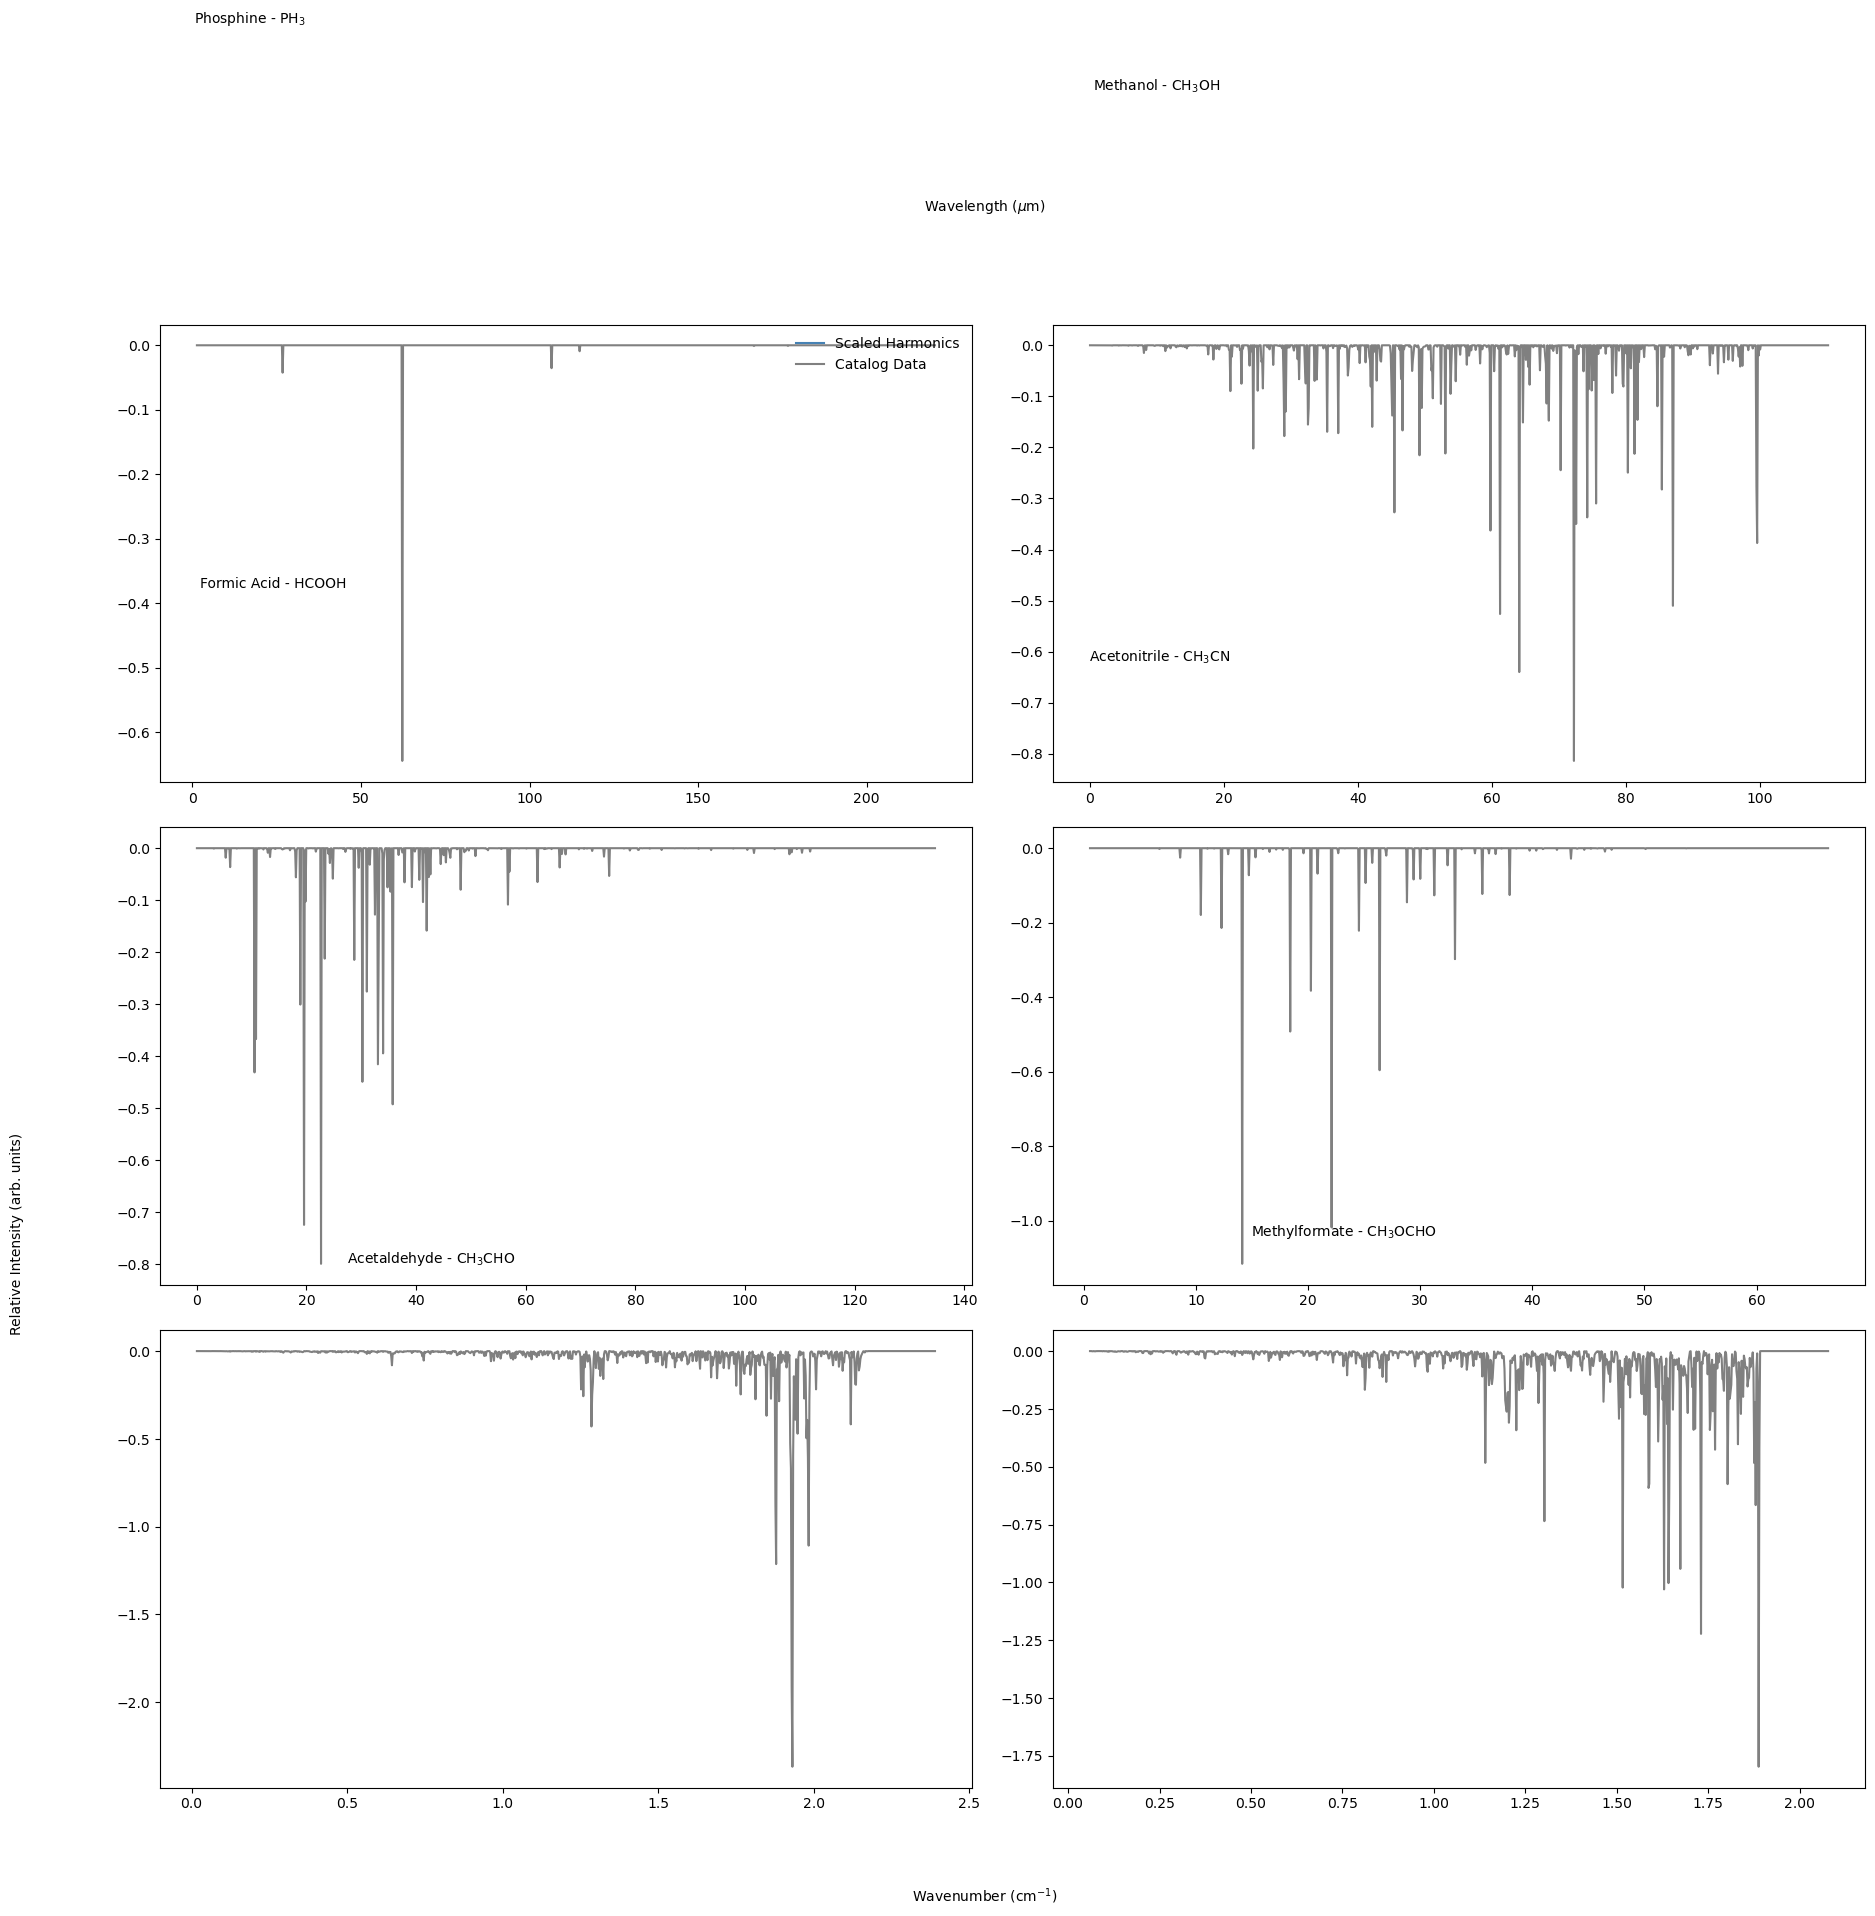

In [13]:
i_index = [0,0,1,1,2,2]
j_index = [0,1,0,1,0,1]

fig, ax = plt.subplots(3,2,figsize=(22,19)) 
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.1)
fig.text(0.06,0.35,"Relative Intensity (arb. units)", rotation = 'vertical', horizontalalignment = 'center')
fig.text(0.5,0.05,"Wavenumber (cm$^{-1}$)", rotation = 'horizontal', horizontalalignment = 'center')
fig.text(0.5,0.94,"Wavelength ($\mu$m)", rotation = 'horizontal', horizontalalignment = 'center')
source_line = Line2D([0], [0], label='Catalog Data', color='grey')
scaled_harm = Line2D([0], [0], label='Scaled Harmonics', color='steelblue')
handles_mc = [scaled_harm,source_line]
ax[0,0].legend(handles= handles_mc, ncol = 1, frameon=False, loc = 'upper right')

for mol in all_list:
    mol_id = mol[0]
    mol_label = mol[1]
    source = mol[2]
    i, j = mol[3], mol[4]
    
    if source == 'CDMS':
        freq, intens = CDMS_get_frequencues_intensities(mol_id)
    elif source == 'JPL':
        freq, intens = JPL_get_frequencues_intensities(mol_id)
    
    plot_CDMS_JPL(freq, intens, source, i , j)
    ax[i,j].text(0.5,0.5,mol_label)

    
plt.show()

In [89]:
freq,intens=JPL_get_frequencues_intensities('41001 CH3CN')
print(len(freq))

    FREQ      ERR    LGINT   DR    ELO    GUP  TAG  QNFMT QN'  QN" 
    MHz       MHz   MHz nm2       1 / cm                           
------------ ------ ------- --- --------- --- ----- ----- ---- ----
   18397.783    0.0 -5.3265   3       0.0   6 41001   202  1 0  0 0
  36794.7651    0.0 -4.5607   3    5.5803  10 41001   202  2 1  1 1
  36795.4747    0.0 -4.4253   3    0.6137  10 41001   202  2 0  1 0
  55188.7268 0.0001  -4.197   3   21.7065  14 41001   202  3 2  2 2
  55191.9193 0.0001 -3.9618   3    6.8077  14 41001   202  3 1  2 1
  55192.9836 0.0001 -3.9003   3     1.841  14 41001   202  3 0  2 0
         ...    ...     ... ...       ... ...   ...   ...  ...  ...
1805453.6797 0.0298 -5.6522   3 3141.7453 796 41001   202 99 6 98 6
1805800.0933  0.031 -5.8402   3 3087.7714 398 41001   202 99 5 98 5
1806083.7062 0.0332 -5.7476   3 3043.5943 398 41001   202 99 4 98 4
1806304.4085 0.0357 -5.3746   3  3009.224 796 41001   202 99 3 98 3
1806462.1144 0.0379 -5.6242   3 2984.6682 398 41